In [ ]:
!pip install myhdl
!pip install myhdlpeek

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.0/164.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.7/253.7 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.2 MB/s eta 0:00:00
  Created wheel for myhdlpeek: filename=myhdlpeek-1.0.0-py2.py3-none-any.whl size=21400 sh

In [ ]:
from myhdl import intbv
from myhdl import block,always
from myhdl import Signal, intbv, delay, always_comb
from myhdl import block, Signal, intbv, instance, delay, Simulation, StopSimulation
from myhdlpeek import Peeker

###Instruction Fetch Block
No pc+1 here as this created a racing condition so we let the Mux take control
also it handles the excution of instructions

In [ ]:
@block
def Fetch_Unit(clock,pc, instructions, inst):
    @always(clock.posedge)
    def logic():
        if int(pc) < len(instructions):
            inst.next = instructions[int(pc)]
            pc.next = pc + 1
    return logic


### **Control** **Unit**

In [ ]:
from myhdl import *

@block
def Control_Unit(
    inst,          # 32-bit instruction input
    RegDst,        # Output: bool (1=rd, 0=rt)
    RegWrite,      # Output: bool
    ALUSrc,        # Output: bool (1=imm, 0=reg)
    ALUOp,         # Output: 3-bit ALU operation
    MemWrite,      # Output: bool
    MemRead,       # Output: bool
    MemToReg,      # Output: bool (1=mem, 0=ALU)
    Branch         # Output: bool
):
    @always_comb
    def logic():
        opcode = inst[32:26]
        funct = inst[6:0] if opcode == 0b000000 else None

        # Default control values (prevent latches)
        RegDst.next = False
        RegWrite.next = False
        ALUSrc.next = False
        ALUOp.next = intbv(0b011)[3:] #INITIALIZED AT 3
        MemWrite.next = False
        MemRead.next = False
        MemToReg.next = False
        Branch.next = False

        if opcode == 0b000000:  # R-type
            RegDst.next = bool(1)  # Explicit bool conversion
            RegWrite.next = bool(1)
            ALUSrc.next = False

            # Decode funct field
            if funct == 0b100000:   # ADD
                ALUOp.next = intbv(0b010)[3:]
            elif funct == 0b100010:  # SUB
                ALUOp.next = intbv(0b110)[3:]
            elif funct == 0b100100:  # AND
                ALUOp.next = intbv(0b000)[3:]
            elif funct == 0b100101:  # OR
                ALUOp.next = intbv(0b001)[3:]
            elif funct == 0b100110:  # XOR
                ALUOp.next = intbv(0b011)[3:]

        # I-Type Instructions
        elif opcode == 0b001000:    # ADDI
            RegWrite.next = True
            ALUSrc.next = True
            ALUOp.next = intbv(0b010)[3:]

        elif opcode == 0b100100:    # SUBI
            RegWrite.next = True
            ALUSrc.next = True
            ALUOp.next = intbv(0b110)[3:]

        elif opcode == 0b100011:    # LW
            RegWrite.next = True
            ALUSrc.next = True
            MemRead.next = True
            MemToReg.next = True
            ALUOp.next = intbv(0b010)[3:]

        elif opcode == 0b101011:    # SW
            ALUSrc.next = True
            MemWrite.next = True
            ALUOp.next = intbv(0b010)[3:]

        elif opcode == 0b000100:    # BEQ
            ALUOp.next = intbv(0b110)[3:]
            Branch.next = True

    return logic

###**Instruction Decoder**
In the instruction decoder i want to do bit slicing so that each part of the instructions is fed seperatly into the Decoder and the inputs will differ (RegWrite/ Selector RegDest) For every insttruction type or according to the function
Write Data will be placed in the WriteReg

In [ ]:
@block
def Decoder_Unit(inst, Rs, Rt, Rd, Immediate, Shamt, Funct, opcode):
    @always_comb
    def logic():
        opcode.next = inst[32:26]
        Rs.next = inst[26:21]
        Rt.next = inst[21:16]
        if opcode == 0b000000:  # R-type
            Rd.next = inst[16:11]
            Shamt.next = inst[11:6]
            Funct.next = inst[6:0]
            Immediate.next = 0
        else:  # I-type
            Immediate.next = inst[16:0]
            Rd.next = 0  # No Rd in I-type
    return logic

### MUX_general

In [ ]:
@block
def Mux(Sel,S1,S2,Output): #output is the WriteReg
  @always_comb
  def mux_logic():
    if Sel==1:
      Output.next=S2
    else:
      Output.next=S1
  return mux_logic

### Sign extender

In [ ]:
@block
def Sign_Extender_Unit(Immediate, Data_32b):
    @always_comb
    def logic():
        sign_bit = Immediate[15]
        # Create a signed intbv that can hold negative values
        extended = intbv(0, min=-2**31, max=2**31)
        extended[15:0] = Immediate  # Copy original bits
        extended[31:16] = 0xFFFF if sign_bit else 0x0000
        Data_32b.next = Immediate.signed() if Immediate else 0
    return logic


###Register File

In [ ]:
@block
def RegisterFile(
    clk,
    Rs,            # 5-bit source register 1
    Rt,            # 5-bit source register 2
    Rd,            # 5-bit destination register
    WriteData,     # 32-bit data to write
    RegWrite,      # Write enable
    ReadData1,     # 32-bit output from Rs
    ReadData2,     # 32-bit output from Rt
    WriteReg,
):

    init_values = [4,5,3,6,7,5,8,7,1,23,55,4,5,65,73,45,16,7,3,22,11,55,15,76,5,3,45,12,23,12,6,0]
    registers = [Signal(intbv(0)[32:]) for _ in range(32)]
    for i in range(32):
      registers[i] = intbv(init_values[i])[32:]

    @always_comb
    def read_logic():
        ReadData1.next = registers[int(Rs)]
        ReadData2.next = registers[int(Rt)]

    @always(clk.posedge)
    def write_logic():
        # If writing to a register, avoid writing to $zero
        if RegWrite and WriteReg != 0:
          registers[int(WriteReg)].next = WriteData

    return read_logic, write_logic


# ALU Block

In [ ]:
@block
def ALU(ALUOp, ReadData1, B, ALU_result, Zero, opcode, writeDataReg):
    """
    Args:
        ALUOp (3-bit): Control signal determining operation.
        ReadData1 (32-bit): First operand (from register).
        B (32-bit): Second operand (could be register or sign-extended immediate).
        ALU_result (32-bit output): Result of ALU operation.
        Zero (1-bit output): 1 if ALU_result == 0 (for BEQ/BNE).
        opcode (6-bit): Instruction opcode (to distinguish R-type vs I-type).
    """

    @always_comb
    def logic():
        # Default values (avoid latches)
        ALU_result.next = 0
        Zero.next = 0

        # R-type instructions (opcode 0b000000)
        if opcode == 0b000000:
            if ALUOp == 0b010:    # ADD (e.g., 'add $rd, $rs, $rt')
                ALU_result.next = ReadData1 + B
            elif ALUOp == 0b110:  # SUB (e.g., 'sub $rd, $rs, $rt')
                ALU_result.next = ReadData1 - B
            elif ALUOp == 0b000:  # AND (e.g., 'and $rd, $rs, $rt')
                ALU_result.next = ReadData1 & B
            elif ALUOp == 0b001:  # OR (e.g., 'or $rd, $rs, $rt')
                ALU_result.next = ReadData1 | B
            elif ALUOp == 0b011:  # XOR (e.g., 'xor $rd, $rs, $rt')
                ALU_result.next = ReadData1 ^ B

        # I-type instructions (ADDI, SUBI, ANDI, ORI, XORI)
        else:

            if ALUOp == 0b010:    # ADDI (e.g., 'addi $rt, $rs, imm')
                ALU_result.next = ReadData1 + B  # B is sign-extended immediate
            elif ALUOp == 0b110:  # SUBI (e.g., 'subi $rt, $rs, imm')
                ALU_result.next = ReadData1 - B  # B is sign-extended immediate
            elif ALUOp == 0b000:  # ANDI (e.g., 'andi $rt, $rs, imm')
                ALU_result.next = ReadData1 & B  # B is zero-extended immediate
            elif ALUOp == 0b001:  # ORI (e.g., 'ori $rt, $rs, imm')
                ALU_result.next = ReadData1 | B  # B is zero-extended immediate
            elif ALUOp == 0b011:  # XORI (e.g., 'xori $rt, $rs, imm')
                ALU_result.next = ReadData1 ^ B  # B is zero-extended immediate

        # Zero flag (for BEQ/BNE)
        Zero.next = 1 if ALU_result == 0 else 0


    @always_comb
    def assign_writeDataReg():
      if RegWrite:
        writeDataReg.next = ALU_result
      else:
        writeDataReg.next = 0

    return logic, assign_writeDataReg


# Memory
Since only the load and the store access the memory, so the ALU result here is the calculated address not the value to be stored in the registers

In [ ]:
@block
def Memory(clk, MemRead, MemWrite, ALU_result, Read_data, Write_data, Data_memory, ReadData2, writeDataMemory):

  @always(clk.posedge)
  def logic():
    #for the lw
    if MemRead:
      Read_data.next = Data_memory[int(ALU_result)] #ALU_result used as an offset
    #for the Sw
    elif MemWrite:
      Data_memory[int(ALU_result)].next = Write_data #ALU_result used as an offset

  @always_comb
  def update_write_data_memory():
    if MemWrite:  # If we are performing a store word (sw) operation
      writeDataMemory.next = ReadData2
    else:
      writeDataMemory.next = 0

  return logic, update_write_data_memory

# Full Adder for branch **calculation**

In [ ]:
@block
def Adder(pc, shifted_Data_32b, branch_target):
    @always_comb
    def logic():
        branch_target.next = pc + shifted_Data_32b
    return logic

Shiftin the offset

In [ ]:
@block
def ShiftLeftby2(Data_32b, shifted_Data_32b):
    @always_comb
    def logic():
        shifted_Data_32b.next = Data_32b << 2
    return logic

# And Gate

In [ ]:
@block
def ANDGate(Branch, Zero, Mux_branch_sel):
    @always_comb
    def logic():
        Mux_branch_sel.next = Branch & Zero
    return logic

MUX

In [ ]:
# Modified Mux with flags
@block
def Mux(Sel, S1, S2, Output):
    @always_comb
    def mux_logic():
        if Sel == 1:
            Output.next = S2
        else:
            Output.next = S1
    return mux_logic

MUX4

In [ ]:
# Modified Mux with flags
@block
def Mux4(Sel, S1, S2, Output):
    @always(Sel)
    def mux_logic():
        if Sel == 1:
            Output.next = S2[5:]
        else:
            Output.next = S1[5:]
    return mux_logic

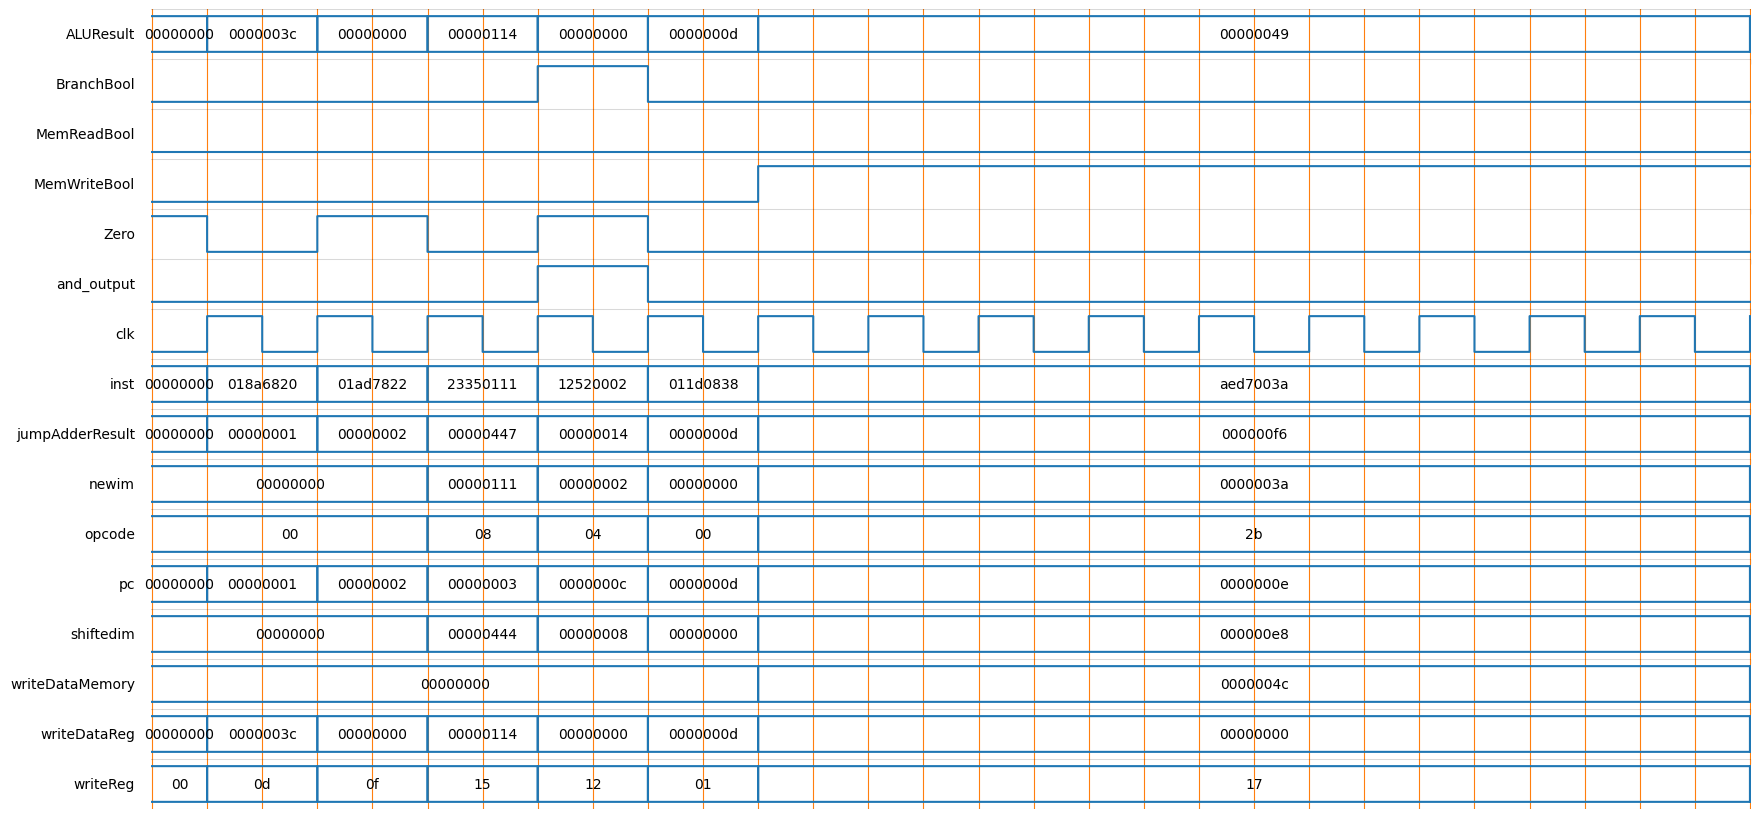

In [ ]:
# Import Peeker for waveform visualization
from myhdlpeek import Peeker

# Read the binary instructions from file
with open("Instructions.txt", "r") as file:
    # Remove newlines and spaces and read as continuous binary string
    binary_data = file.read().replace("\n", "").replace(" ", "")

    # Convert binary string to list of 32-bit instruction vectors
    instructions = [intbv(int(binary_data[i:i+32], 2))[32:]
                   for i in range(0, len(binary_data), 32)]

###############################################################################
# CORE PROCESSOR SIGNALS
###############################################################################

# Instruction Fetch Signals
inst = Signal(intbv(0)[32:])       # Current instruction being executed
pc = Signal(intbv(0)[32:])         # Program counter (current instruction address)
pc_plus_1 = Signal(intbv(0)[32:])  # PC + 1 (for word-addressable memory)
pc_next = Signal(intbv(0)[32:])    # Next PC value (for branches/jumps)
clk = Signal(bool(0))              # System clock

# Instruction Decoding Signals
opcode = Signal(intbv(0)[6:])      # Opcode field (bits 31-26)
Rs = Signal(intbv(0)[5:])          # rs field (bits 25-21, source register 1)
Rt = Signal(intbv(0)[5:])          # rt field (bits 20-16, source register 2)
Rd = Signal(intbv(0)[5:])          # rd field (bits 15-11, destination register)
Immediate = Signal(intbv(0)[16:])  # Immediate field (bits 15-0)
Shamt = Signal(intbv(0)[5:])       # Shift amount field (bits 10-6)
Funct = Signal(intbv(0)[6:])       # Function code field (bits 5-0, for R-type)

###############################################################################
# CONTROL UNIT SIGNALS
###############################################################################

RegDst = Signal(bool(0))    # Selects destination register (1=Rd, 0=Rt)
RegWrite = Signal(bool(0))  # Register file write enable
ALUSrc = Signal(bool(0))    # Selects ALU source (1=Immediate, 0=ReadData2)
ALUOp = Signal(intbv(0)[3:]) # ALU operation control code
MemWrite = Signal(bool(0))  # Data memory write enable
MemRead = Signal(bool(0))   # Data memory read enable
MemToReg = Signal(bool(0))  # Selects writeback data (1=Memory, 0=ALU)
Branch = Signal(bool(0))    # Branch control signal

###############################################################################
# DATAPATH SIGNALS
###############################################################################

# Register File Signals
ReadData1 = Signal(intbv(0)[32:])  # Data read from register rs
ReadData2 = Signal(intbv(0)[32:])  # Data read from register rt
WriteData = Signal(intbv(0)[32:])  # Data to be written to register file
WriteReg = Signal(intbv(0)[5:])    # Destination register address

# ALU Signals
A = Signal(intbv(0)[32:])           # ALU input 1 (from ReadData1)
B = Signal(intbv(0)[32:])           # ALU input 2 (from Mux_ALUSrc) either form readdata 2 or immediate
ALU_result = Signal(intbv(0, min=-2**31, max=2**31))  # ALU result (signed)
Zero = Signal(bool(0))              # Zero flag (1 when ALU result is zero)

# Memory Signals
writeDataReg = Signal(intbv(0, min=-2**31, max=2**31))  # Data to write to reg (signed)
writeDataMemory = Signal(intbv(0, min=-2**31, max=2**31))  # Data to write to mem (signed)
Read_data = Signal(intbv(0, min=-2**31, max=2**31))  # Data read from memory (signed)
Data_memory = [Signal(intbv(0)[32:]) for _ in range(1000)]  # Data memory array

# Branch/Jump Signals
and_output = Signal(bool(0))        # AND gate output (Branch & Zero)
branch_target = Signal(intbv(0)[32:])  # Branch target address (PC + offset)
reset = Signal(bool(1))             # System reset (active high)
shifted_Data_32b = Signal(intbv(0)[32:])  # Sign-extended immediate shifted left by 2
Data_32b = Signal(intbv(0, min=-2**31, max=2**31))  # Sign-extended immediate

@block
def Top_Module():
    """
    Top-level module that instantiates and connects all processor components.
    Also sets up signal monitoring with Peeker for waveform visualization.
    """

    ###########################################################################
    # SIGNAL MONITORING SETUP (for waveform visualization)
    ###########################################################################

    # Core signals
    Peeker(inst, 'inst')            # Current instruction
    Peeker(pc, 'pc')                # Program counter
    Peeker(clk, 'clk')              # Clock signal
    Peeker(opcode, 'opcode')        # Instruction opcode

    # Data path signals
    Peeker(writeDataMemory, 'writeDataMemory')  # Data to be written to memory
    Peeker(writeDataReg, 'writeDataReg')       # Data to be written to register
    Peeker(WriteReg, 'writeReg')               # Destination register address
    Peeker(Data_32b, 'newim')                  # Sign-extended immediate
    Peeker(ALU_result, 'ALUResult')            # ALU computation result
    Peeker(Zero, 'Zero')                       # ALU zero flag

    # Branch control signals
    Peeker(branch_target, 'jumpAdderResult')   # Branch target address
    Peeker(and_output, 'and_output')           # Branch condition (AND gate output)
    Peeker(shifted_Data_32b, 'shiftedim')      # Shifted immediate (for branch offset)

    # Memory control signals
    Peeker(MemWrite, 'MemWriteBool')           # Memory write enable
    Peeker(MemRead, 'MemReadBool')             # Memory read enable
    Peeker(Branch, 'BranchBool')               # Branch instruction flag

    ###########################################################################
    # COMPONENT INSTANTIATION
    ###########################################################################

    # Instruction Fetch Stage
    Fetch = Fetch_Unit(clk, pc, instructions, inst)

    # Control Unit
    Control = Control_Unit(inst, RegDst, RegWrite, ALUSrc, ALUOp,
                          MemWrite, MemRead, MemToReg, Branch)

    # Register Destination Mux (selects Rd or Rt as destination register)
    Mux_RegDst = Mux(RegDst, Rt, Rd, WriteReg)

    # Instruction Decoder
    Decoder = Decoder_Unit(inst, Rs, Rt, Rd, Immediate, Shamt, Funct, opcode)

    # Sign Extension Unit
    Sign_Extender = Sign_Extender_Unit(Immediate, Data_32b)

    # Register File
    RegFile = RegisterFile(clk, Rs, Rt, Rd, WriteData, RegWrite,
                         ReadData1, ReadData2, WriteReg)

    # ALU Source Mux (selects register data or immediate)
    Mux_ALUSrc = Mux(ALUSrc, ReadData2, Data_32b, B)

    # ALU
    ALU_Module = ALU(ALUOp, ReadData1, B, ALU_result, Zero, opcode, writeDataReg)

    # Data Memory
    Memory_Module = Memory(clk, MemRead, MemWrite, ALU_result,
                          Read_data, WriteData, Data_memory, ReadData2, writeDataMemory)

    # Memory-to-Register Mux (selects ALU result or memory data for writeback)
    Mux_MemToReg = Mux(MemToReg, Read_data, ALU_result, WriteData)

    # Branch Control Logic
    and_gate = ANDGate(Branch, Zero, and_output)  # AND gate for branch condition
    shifter = ShiftLeftby2(Data_32b, shifted_Data_32b)  # Shift immediate for branch offset
    full_adder = Adder(pc, shifted_Data_32b, branch_target)  # Calculate branch target
    mux_branch = Mux4(and_output, pc, branch_target, pc)  # Select next PC (branch or PC+4)

    return (Fetch, Control, Mux_RegDst, Decoder, Sign_Extender, RegFile,
           Mux_ALUSrc, ALU_Module, Memory_Module, Mux_MemToReg, full_adder,
           and_gate, mux_branch, shifter)


@block
def test_bench():
    """
    Test bench for the processor simulation.
    Generates clock cycles and runs the simulation.
    """
    @instance
    def tb_process():
        # Generate clock cycles for simulation
        for cycle in range(30):
            yield delay(1)
            clk.next = not clk  # Toggle clock each time unit

        raise StopSimulation  # End simulation after 30 cycles

    return tb_process


# Create and run the simulation
tb = test_bench()
top = Top_Module()
sim = Simulation(top, tb, *Peeker.instances())
sim.run()

# Display waveforms after simulation
Peeker.show_waveforms(width=20, slope=0)
Peeker.clear()  # Clean up Peeker instances